# Airlines Passenger Traffic : Time Series Analysis

## 1. Importing necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("Necessary packages imported successfully!")

Necessary packages imported successfully!


## 2. Importing the datasets

In [5]:
data = pd.read_csv("AirPassengers.csv")
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


## 3. Plotting the time series data

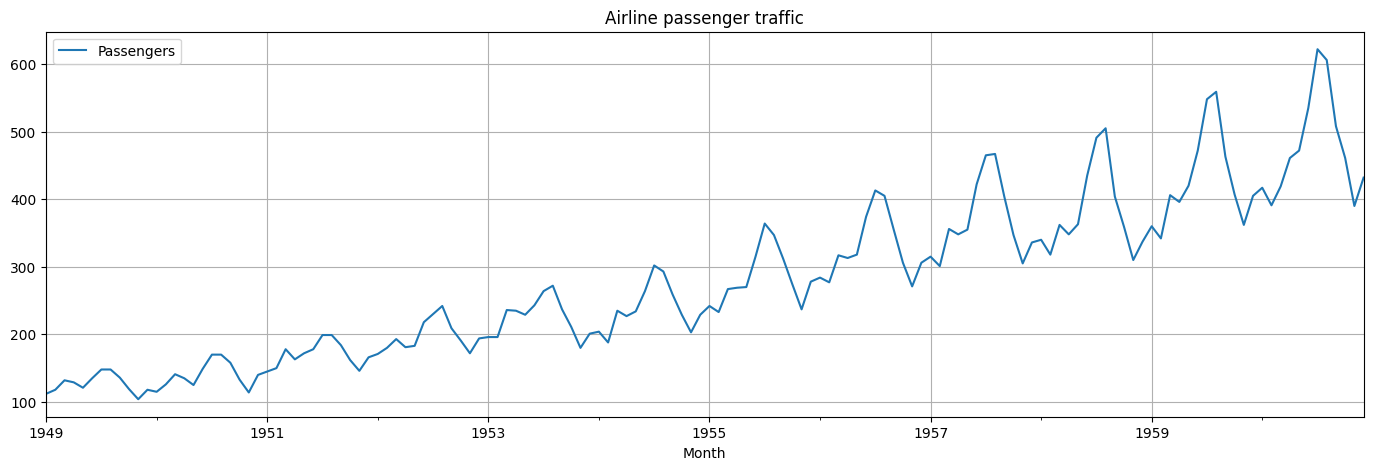

In [6]:
data.plot(figsize=(17, 5))
plt.legend(loc='best')
plt.grid()
plt.title('Airline passenger traffic')
plt.show(block=False)

## 4. Handling missing data

### (Removing null values by mean imputation)

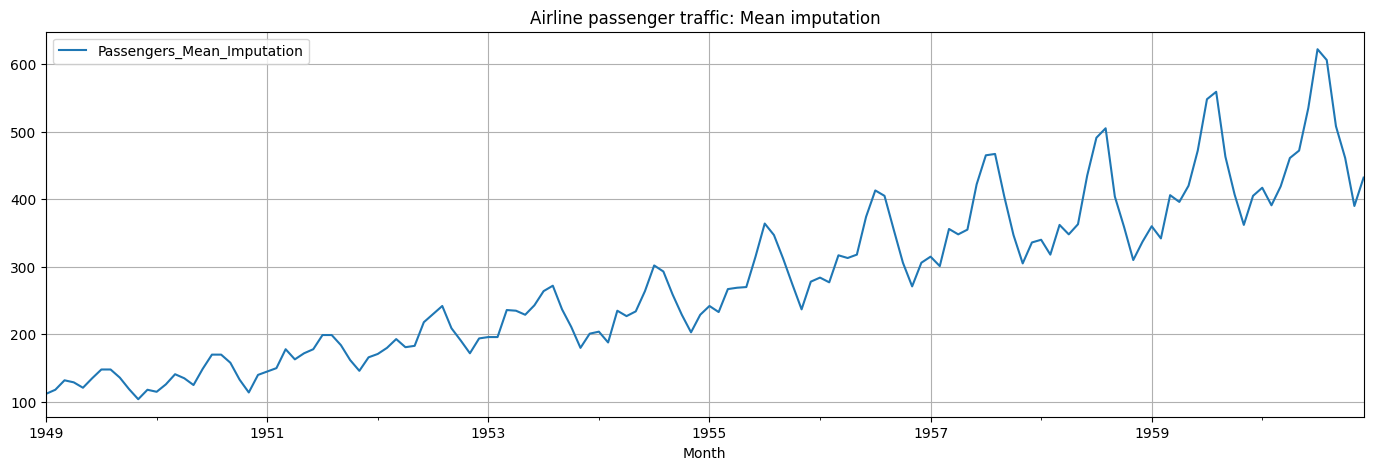

In [7]:
data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(17, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Airline passenger traffic: Mean imputation')
plt.show(block=False)

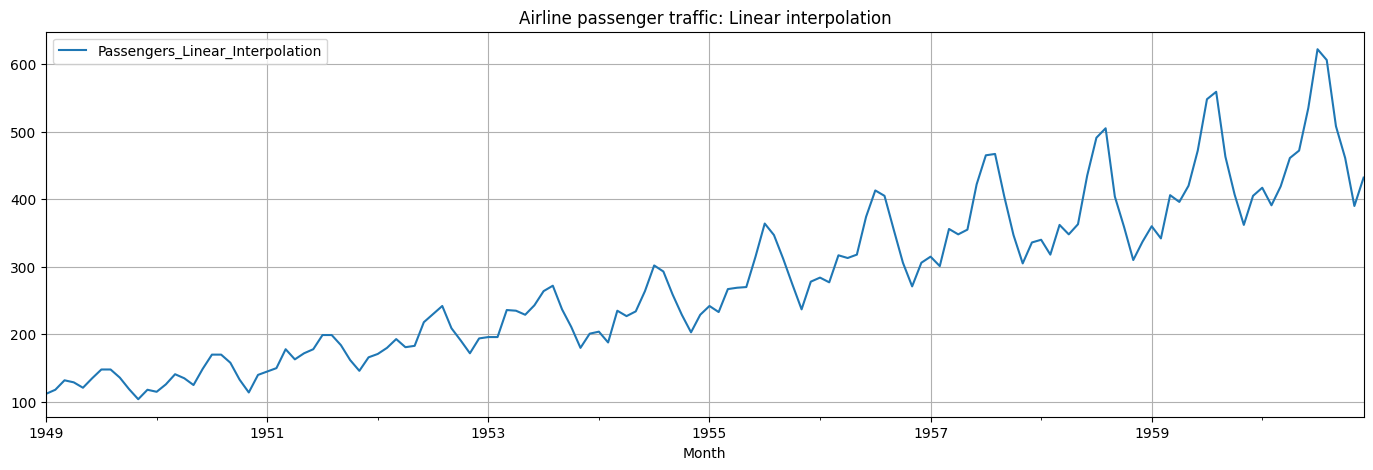

In [8]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(17, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

In [9]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

## 5. Checking for outliers

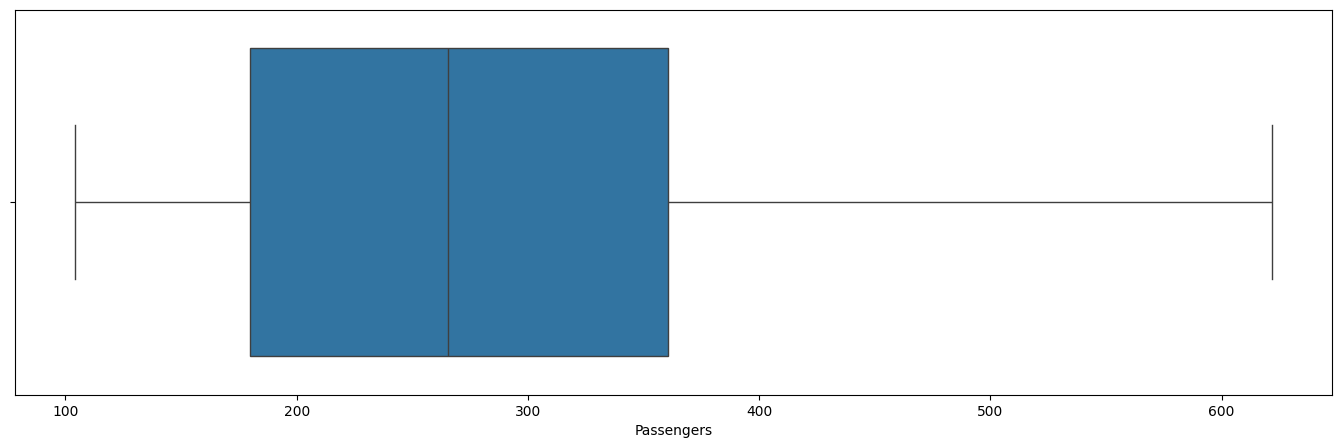

In [10]:
fig = plt.subplots(figsize=(17, 5))
ax = sns.boxplot(x=data['Passengers'],whis=1.5)

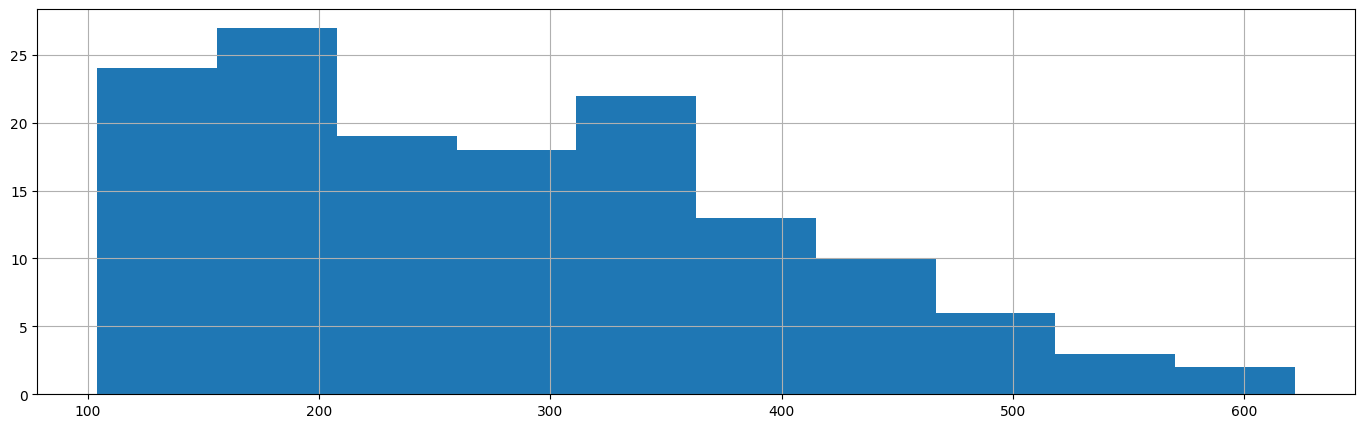

In [11]:
fig = data.Passengers.hist(figsize = (17,5))

## **Time series = Trend + Seasonality + Residuals**

    
- **Trend**: general direction of the series (e.g. increasing)
- **Seasonality**: repeating patterns in data (e.g. sales around holidays..)
- **Residuals**: the rest

`statsmodels.tsa.seasonal.seasonal_decompose()` takes a DataFrame and returns an object with attributes:
- `.trend`
- `.seasonal`
- `.resid`
each containing the time series that encodes the corresponding part of the original series,

and a method
- `.plot()`
which makes 4 plots:  original series + 3 its components

## 6. Time series decomposition

### i. Additive seasonal decomposition

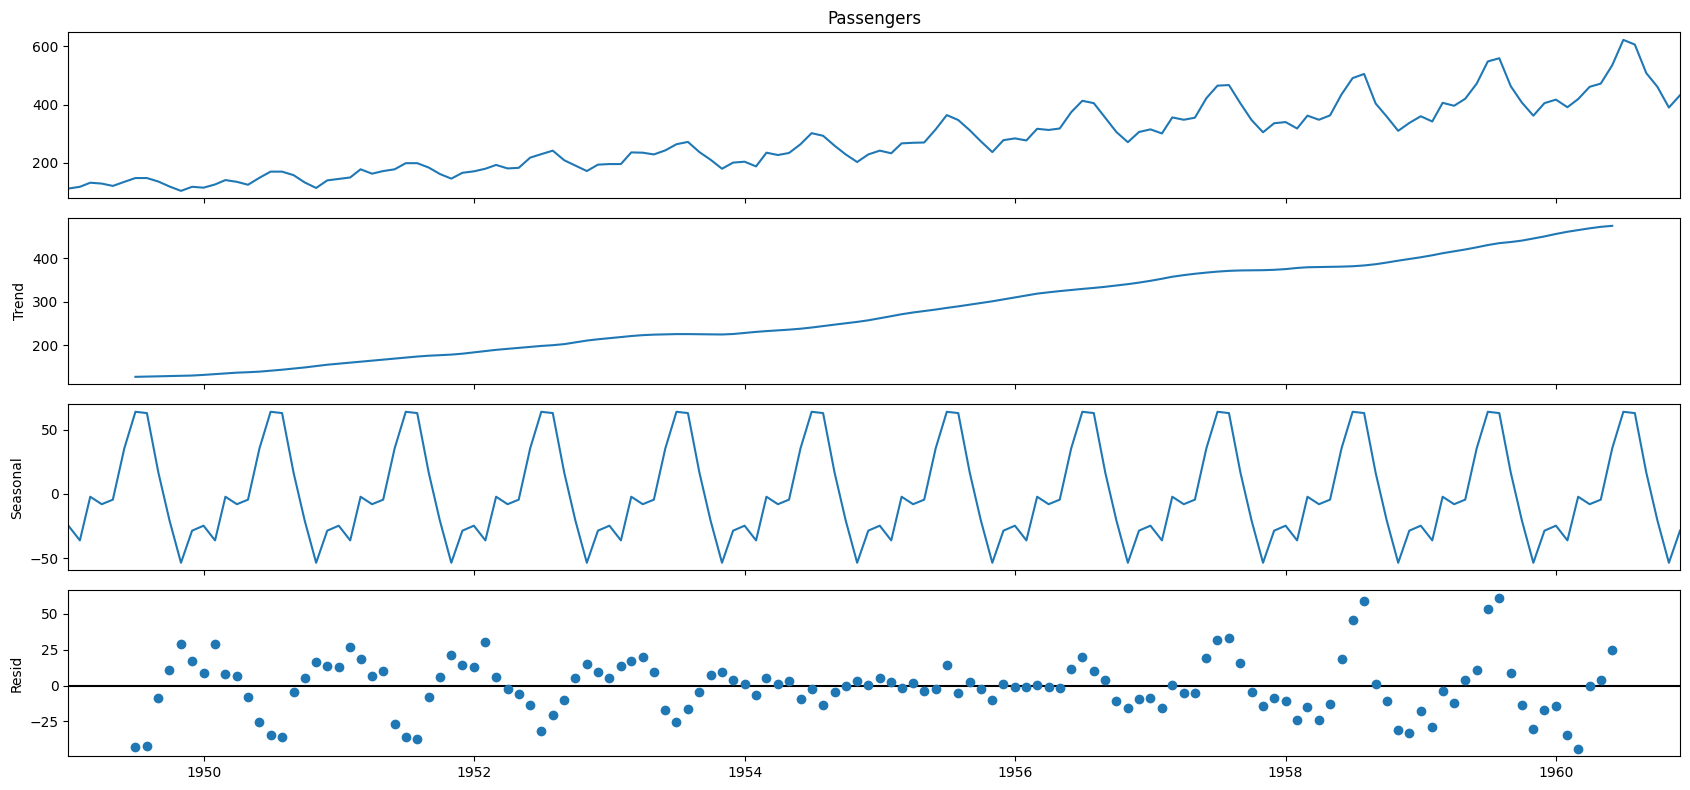

In [12]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 17, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### ii. Multiplicative seasonal decomposition

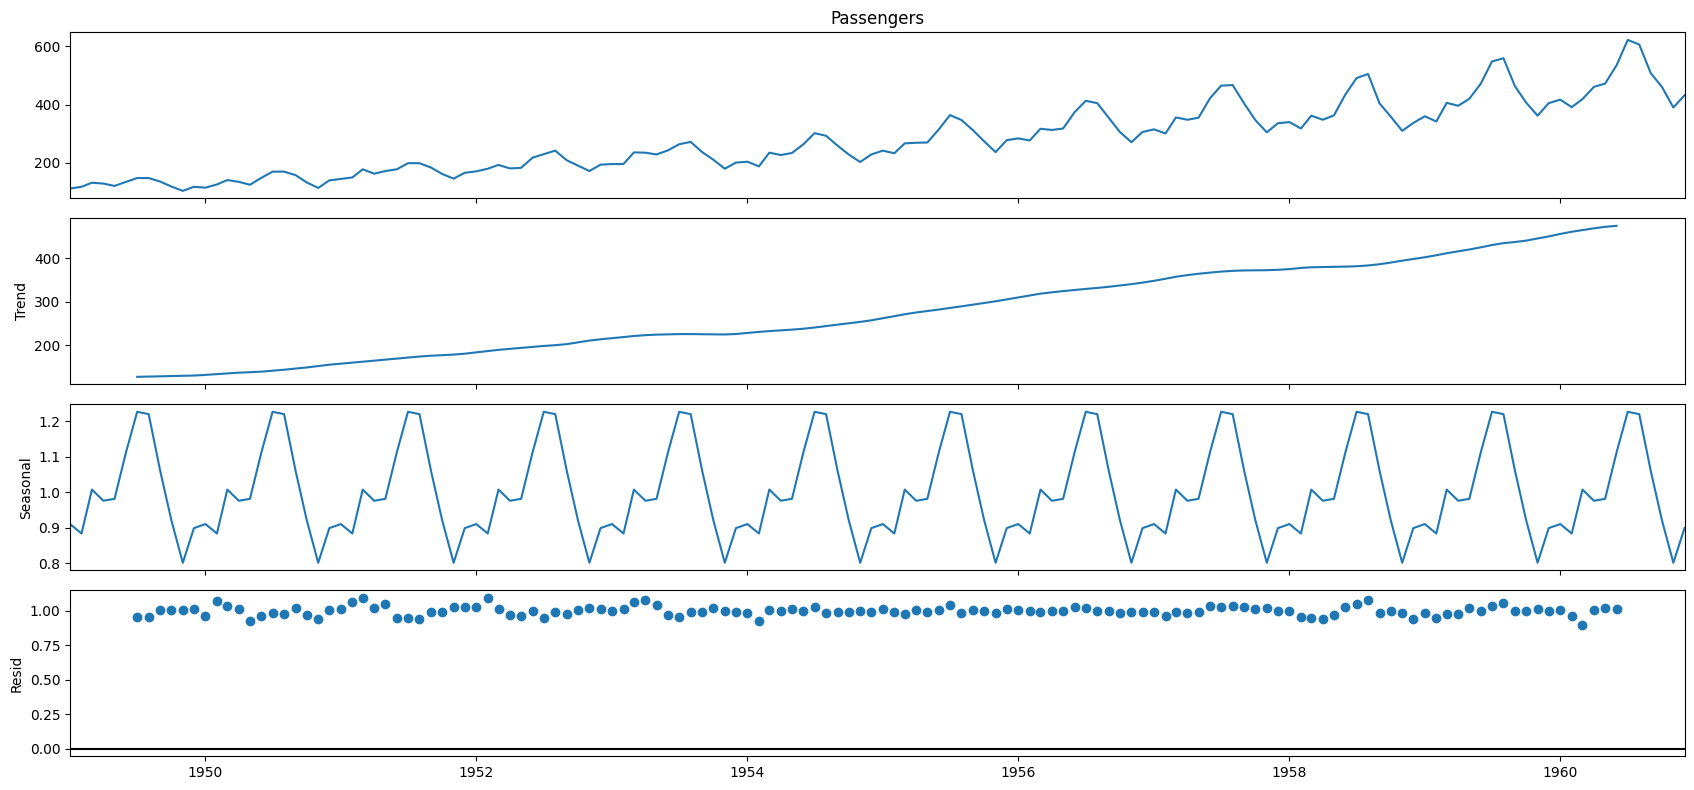

In [13]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## 7. Building time series forcast model

### i. splitting the dataset on timeline

In [14]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

### ii. Naive method

In [15]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

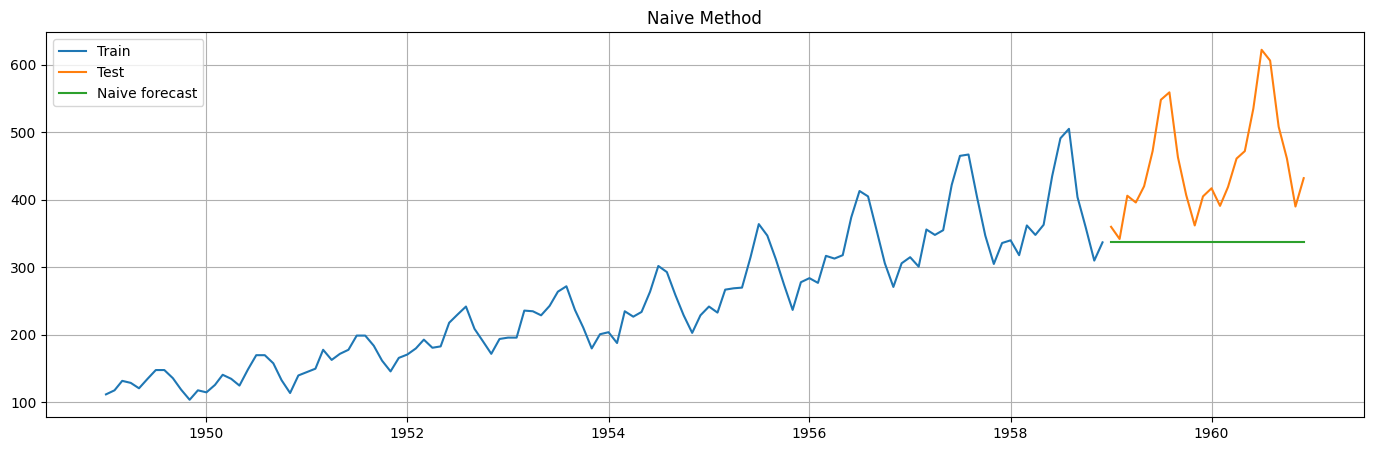

In [16]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [17]:
## calculating RMSE and MAPE scores
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58


### iii. Simple average method

In [18]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

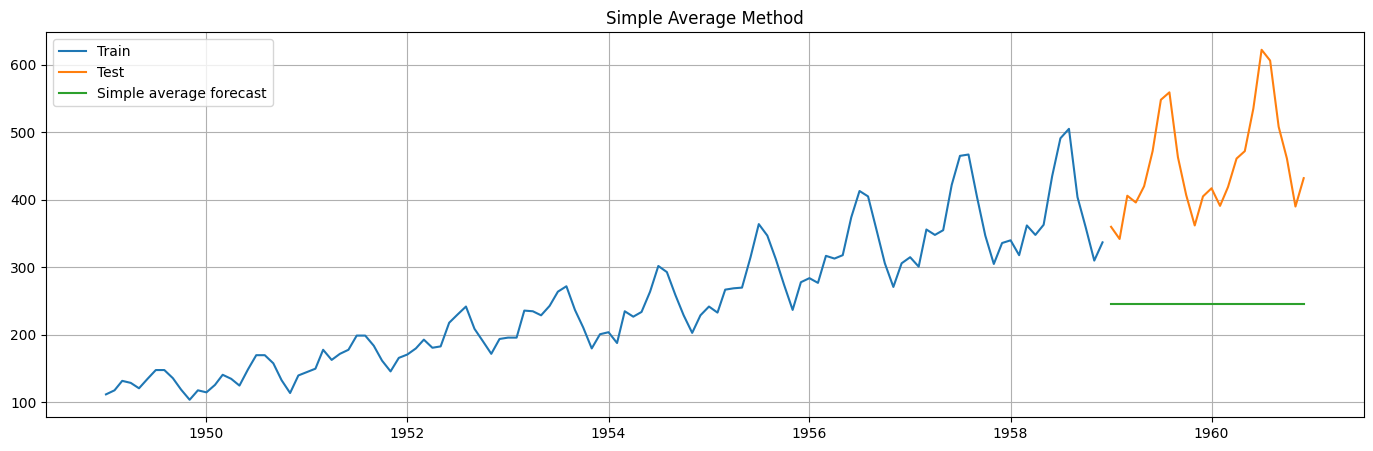

In [19]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [20]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23


### iv. Simple moving average method

## **Smoothing: rolling windows**

Even after resampling, the trends and patterns might be hard to see.

> **Rolling aggregation** creates a _new_ time series: the value for each timestamp is an aggregation of a fixed number of previous values.


<font color = AAAAAA><i>
- Value for today = Average of values since last Tuesday
- Value for yesterday = Average of values since last Monday
- Value for Sunday = Average of values since Sunday before that
- ...
</i></font>
$U_t = \frac{1}{7}(Y_t + Y_{t-1} + Y_{t-2} + Y_{t-3} + Y_{t-4} + Y_{t-5}+ Y_{t-6})$


|date|original series|rolling window series|
|---|---|---|
|2020-05-01| 5 |NaN|
|2020-05-02| 7 |NaN|
|2020-05-03| 9 |NaN|
|2020-05-04| 11|NaN|
|2020-05-05| 13|NaN|
|2020-05-06| 15|NaN|
|2020-05-07| 17| (NaN|
|2020-05-08| 2 | (5 + 7 + 9 + 11 + 13 + 15 + 17)/7|
|2020-05-09| 4 | (7 + 9 + 11 + 13 + 15 + 17 +2)/7|
|2020-05-10| 6 | (9 + 11 + 13 + 15 + 17 +2 +4)/7|
|2020-05-11| 8 | (11 + 13 + 15 + 17 +2 +4 +6)/7|
|2020-05-12| 10 | (13 + 15 + 17 +2 +4 +6 + 8)/7|
|2020-05-13| 12 |(15 + 17 +2 +4 +6 + 8 +10)/7|
|2020-05-14| 14 |(17 +2 +4 +6 + 8 +10 + 12)/7|

<br>

<font size = 5> larger window = less detail = more smooth</font>


##### **Steps of rolling window smoothing:**

1. `.rolling(n_periods)`...

2. aggregate `.mean()`, `.sum()`



In [21]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

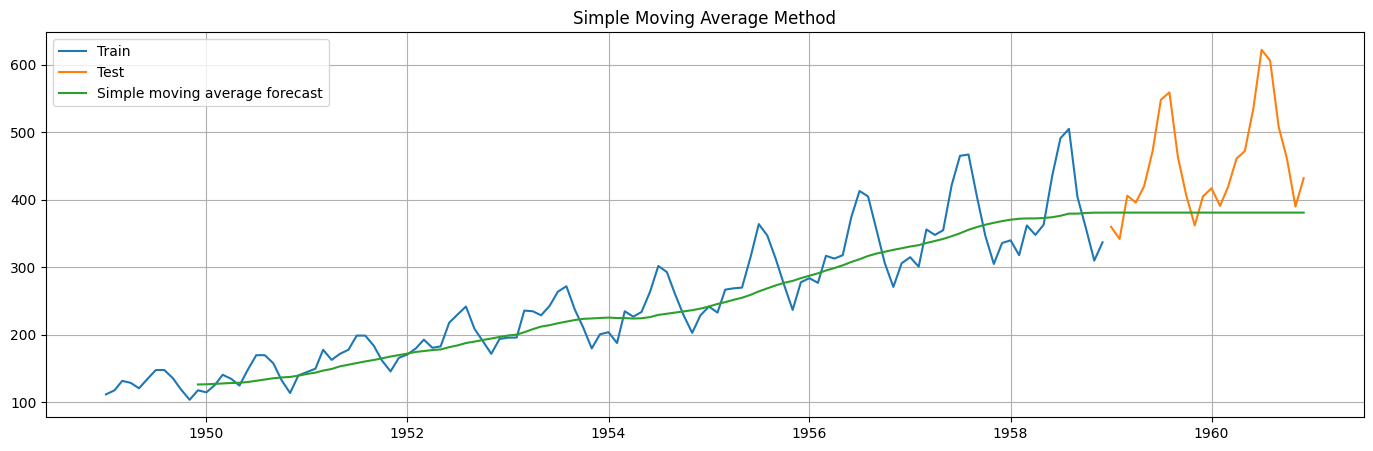

In [22]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [23]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47


### v. Simple exponential smoothening

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

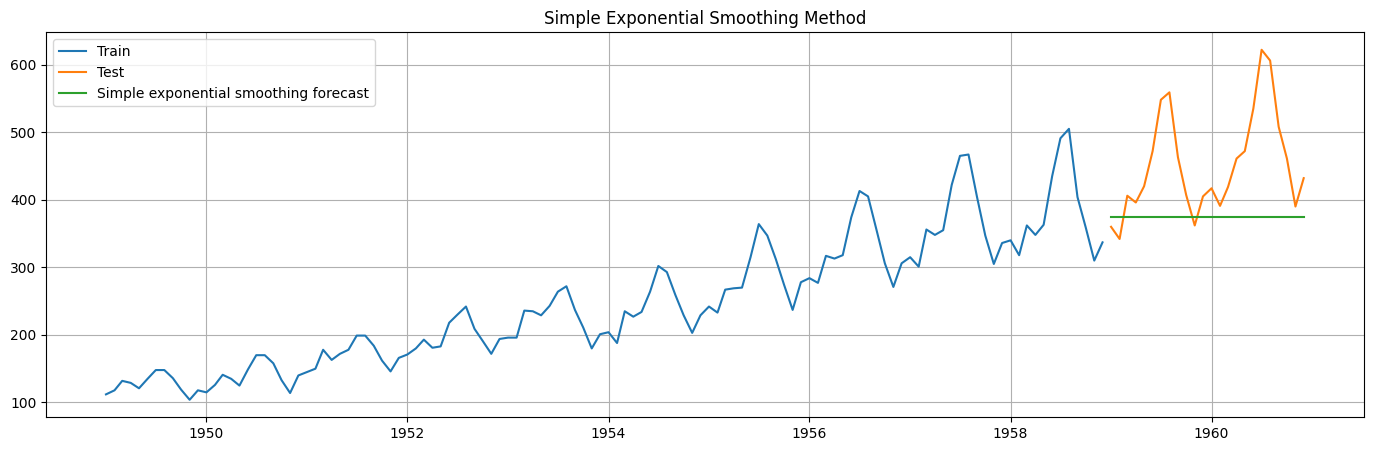

In [25]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [26]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43


### vi. Holt's method with trend

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': np.float64(118.46666666666658), 'initial_trend': np.float64(2.060606060606071), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


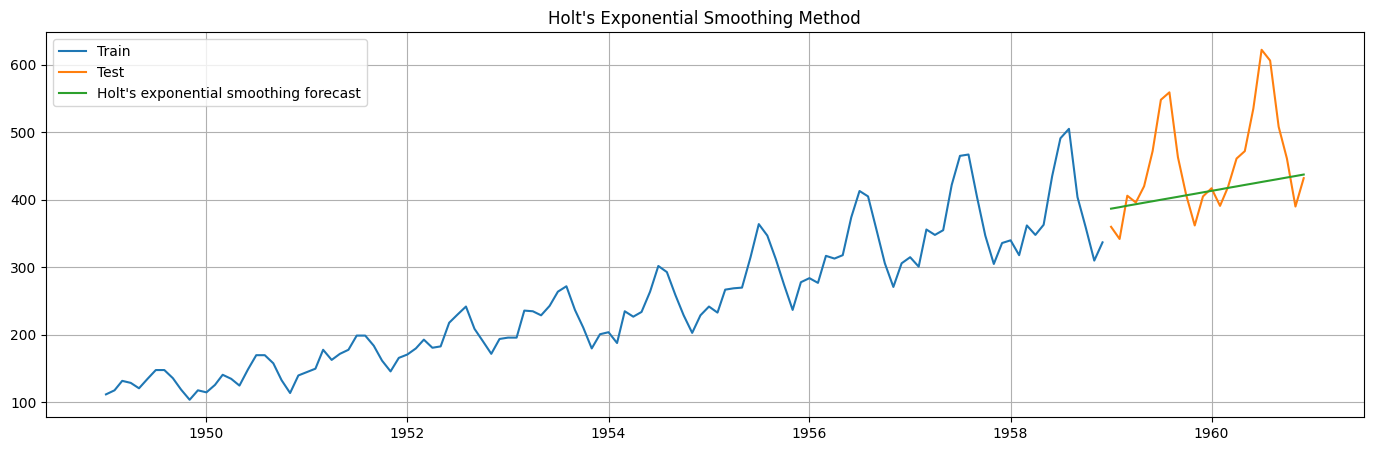

In [28]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32


### vii. Holt Winter's additive method with trend and seasonality

In [30]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': np.float64(0.23674834473953665), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(0.7632516552604633), 'damping_trend': nan, 'initial_level': np.float64(119.18569488693261), 'initial_trend': np.float64(2.276546300320331), 'initial_seasons': array([ -9.49046545,  -3.90684366,   8.6696783 ,   3.68220105,
        -4.94464086,   9.24735598,  21.50903488,  19.19082528,
         5.10076103, -13.75289202, -28.45157749, -12.34204183]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


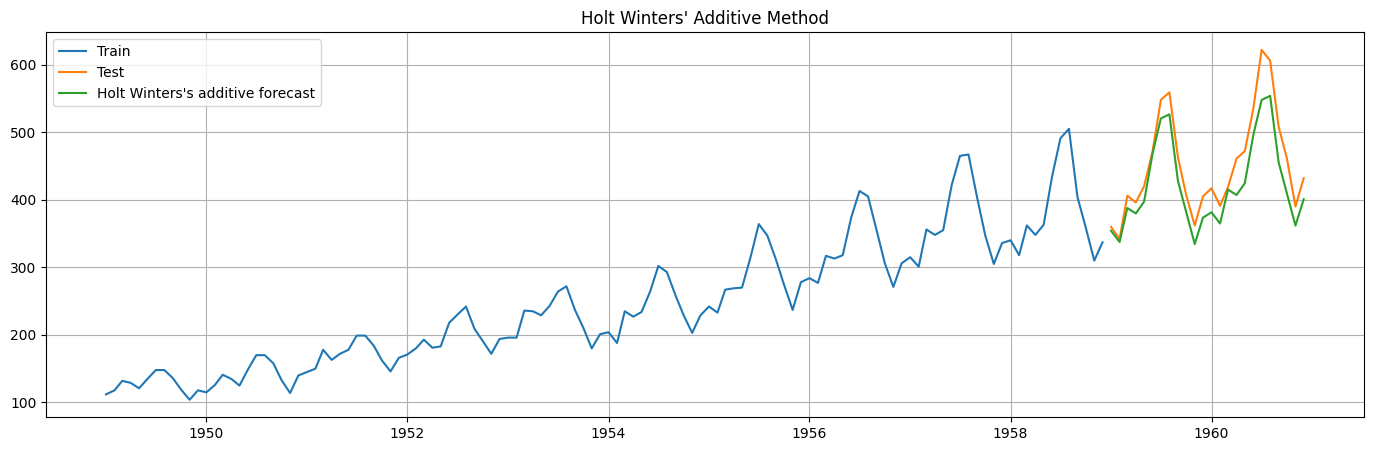

In [31]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64


### viii.Holt Winter's multiplicative method with trend and seasonality

In [33]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': np.float64(0.3642176699401052), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(0.6357823300598948), 'damping_trend': nan, 'initial_level': np.float64(124.65581481881696), 'initial_trend': np.float64(2.6858011135368267), 'initial_seasons': array([0.87952394, 0.92440521, 1.01607883, 0.96690256, 0.89504973,
       0.98249054, 1.07135561, 1.05860274, 0.96576171, 0.84138902,
       0.74731089, 0.8613039 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


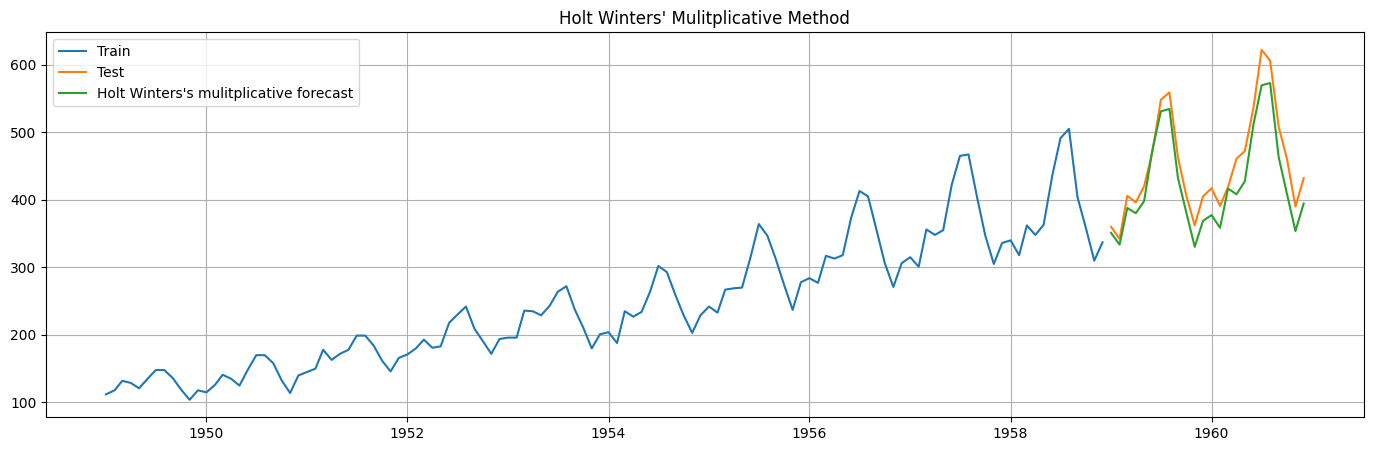

In [34]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [35]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39


# **Autocorrelation**

For prediction, we need to know how future values of time series depend on the past values.

Correlation of two _random variables_ is a measure of dependency of one variable on the other. For time series, *auto*correlation, as the name might suggest, will measure self-correlation &mdash; the dependency of time series on itself.


## **Lags**

Lagged time series is just the same time series shifted by a certain number of days/weeks/month, called the _lag_, into the past:
<!--
|date|original series|lag-2 series|
|---|---|---|
|2020-05-01| 5 |NaN|
|2020-05-02| 7 |NaN|
|2020-05-03| 9 |5|
|2020-05-04| 11|7|
|2020-05-06| 13|9|
|2020-05-07| 15|11|
|2020-05-08| 17| 13|
|2020-05-08| 2 | 15|
|2020-05-10| 4 | 17|
|2020-05-11| 6 | 2|
|2020-05-12| 8 | 4|
|2020-05-13| 10 | 6|
|2020-05-14| 12 |8|
|2020-05-15| 14 |10|
-->
<img src = "https://github.com/datacamp/time-series-analysis-in-python-live-training/raw/master/assets/lag-1.png" height=400pt>
<img src = "https://github.com/datacamp/time-series-analysis-in-python-live-training/raw/master/assets/lag-2.png" height=400pt>

Notice the `NaN`s! The bigger the lag is, the shorter the lagged series will be.

## **Autocorrelation function**
Function of the lag $\mathbf{n}$.

$$\large{Autocorr(\mathbf{n}) = corr(series, \,lag\,\mathbf{n}\, series)}$$

Measures how much the value of the series now depends on the value $\mathbf{n}$ days ago.


`statsmodels` offers two functions related to autocorrelation:
- `statsmodels.tsa.stattools.acf()`  will compute the ACF for a time series passed to it, with 40 lags range by default
- `statsmodels.graphics.tsaplots.plot_acf()` will just plot the ACF -- which is usually what we want


### ix. Auto-regressive model : Stationary and non-stationary

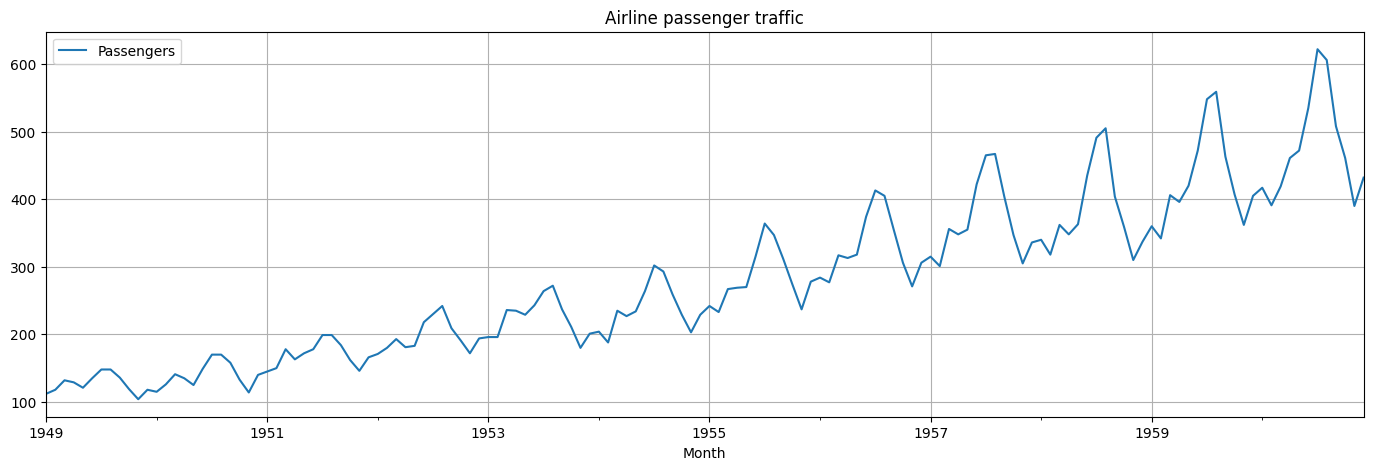

In [36]:
data['Passengers'].plot(figsize=(17, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### x. Augmented Dickey-Fuller Test

In [37]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

# The ADF Statistic (0.866288) is much greater than the Critical Value @ 0.05 (-2.88).
# The p-value (0.992634) is much greater than 0.05.
# Hence, we fail to reject the null hypothesis and conclude that the time series is non-stationary.

ADF Statistic: 0.815369
Critical Values @ 0.05: -2.88
p-value: 0.991880


### xi. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [38]:
#KPSS Test is opposite of ADF Test
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

# KPSS Statistic: 1.044840
# Critical Values @ 0.05: 0.46
# p-value: 0.010000

# As the KPSS statistic (1.044840) is greater than the Critical Value @ 0.05 (0.46), 
# and the p-value (0.010000) is less than 0.05, 
# we reject the null hypothesis and conclude that the time series is non-stationary.

KPSS Statistic: 1.651312
Critical Values @ 0.05: 0.46
p-value: 0.010000


# **Stationarity**

Most time series models assume that the time series is _stationary_. In plain language, that means that the features of the series do not depend on the _time_ when they occur (but they might depend on the past _values_). This means, among other things:

- Constant mean
- Contant variance

**Time series that exhibit trend and seasonality are not stationary.**

Most time series models assume stationarity of the series they model, so you often need to remove trend and seasonality from the series, build the model, then put it back.


### Detrending - How to make a time series stationary?

- We can apply some sort of transformation to make the time-series stationary. These transformation may include:
- Differencing the Series (once or more)
- Take the log of the series
- Take the nth root of the series
- Combination of the above
The most commonly used and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

### Introduction to Differencing for 

- If Y_t is the value at time t, then the first difference of Y = Yt – Yt-1. In simpler terms, differencing the series is nothing but subtracting the next value by the current value.
- If the first difference doesn’t make a series stationary, we can go for the second differencing and so on.
- For example, consider the following series: [1, 5, 2, 12, 20]
- First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]
- Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]

### xii. Box Cox transformation : To make the variant constant

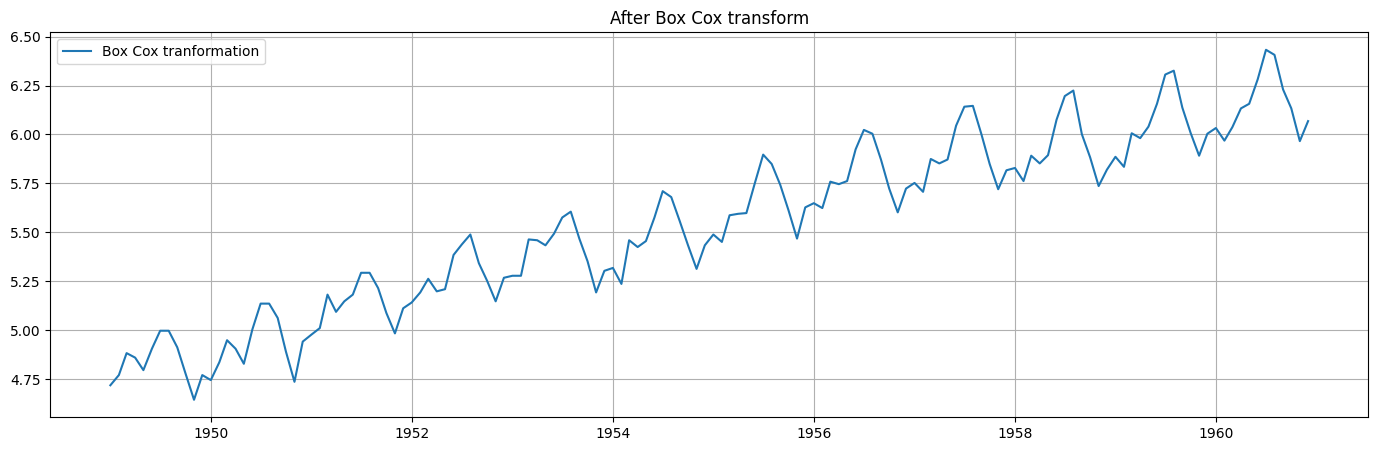

In [39]:
from scipy.stats import boxcox
# lmbda=0 for the Box-Cox transformation, which specifically corresponds to a natural logarithm transformation (log(x))
#
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

plt.figure(figsize=(17,5))
plt.grid()
plt.plot(data_boxcox, label='Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### xiii. Trend removal by differencing

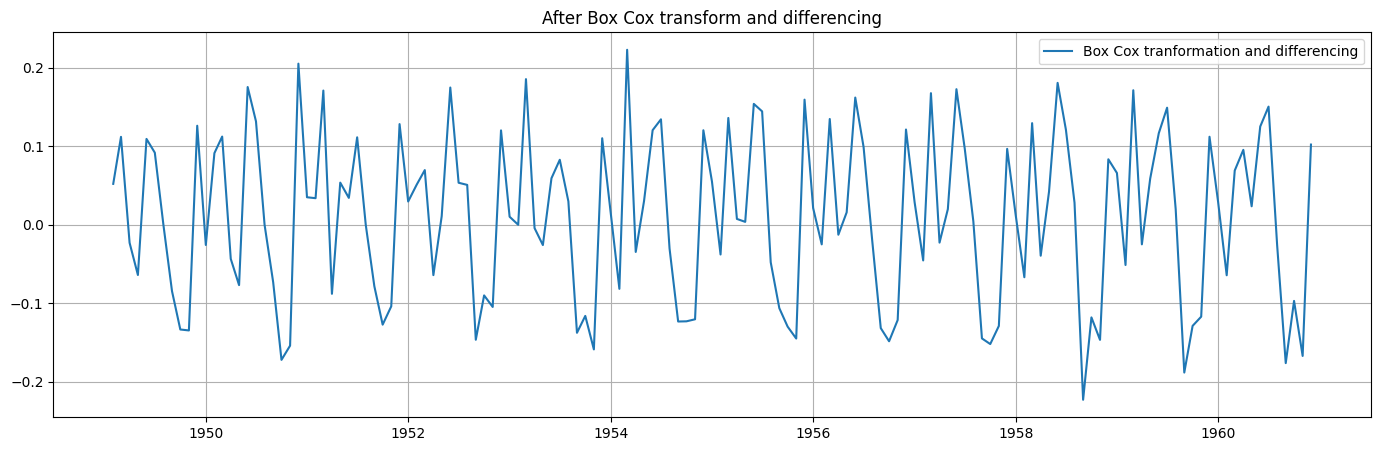

In [40]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(data_boxcox_diff, label='Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [41]:
data_boxcox_diff.dropna(inplace=True)

In [42]:
data_boxcox_diff.tail()

Month
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
dtype: float64

In [43]:
## Performing augmented Dickey-Fuller test to check for trend
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

# ADF Statistic: -3.267370
# Critical Values @ 0.05: -2.88
# p-value: 0.016402
# As the ADF Statistic (-3.267370) is less than the Critical Value @ 0.05 (-2.88),
# and the p-value (0.016402) is less than 0.05,
# we reject the null hypothesis and conclude that the time series is stationary.

ADF Statistic: -2.717131
Critical Values @ 0.05: -2.88
p-value: 0.071121


In [44]:
## KPSS test
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

# KPSS Statistic: 0.034137
# Critical Values @ 0.05: 0.46
# p-value: 0.100000
# As the KPSS statistic (0.034137) is less than the Critical Value @ 0.05 (0.46), 
# and the p-value (0.100000) is greater than 0.05, 
# we fail to reject the null hypothesis and conclude that the time series is stationary.

KPSS Statistic: 0.038304
Critical Values @ 0.05: 0.46
p-value: 0.100000


Text(0.5, 1.0, 'Air Passengers detrended by subtracting the least squares fit')

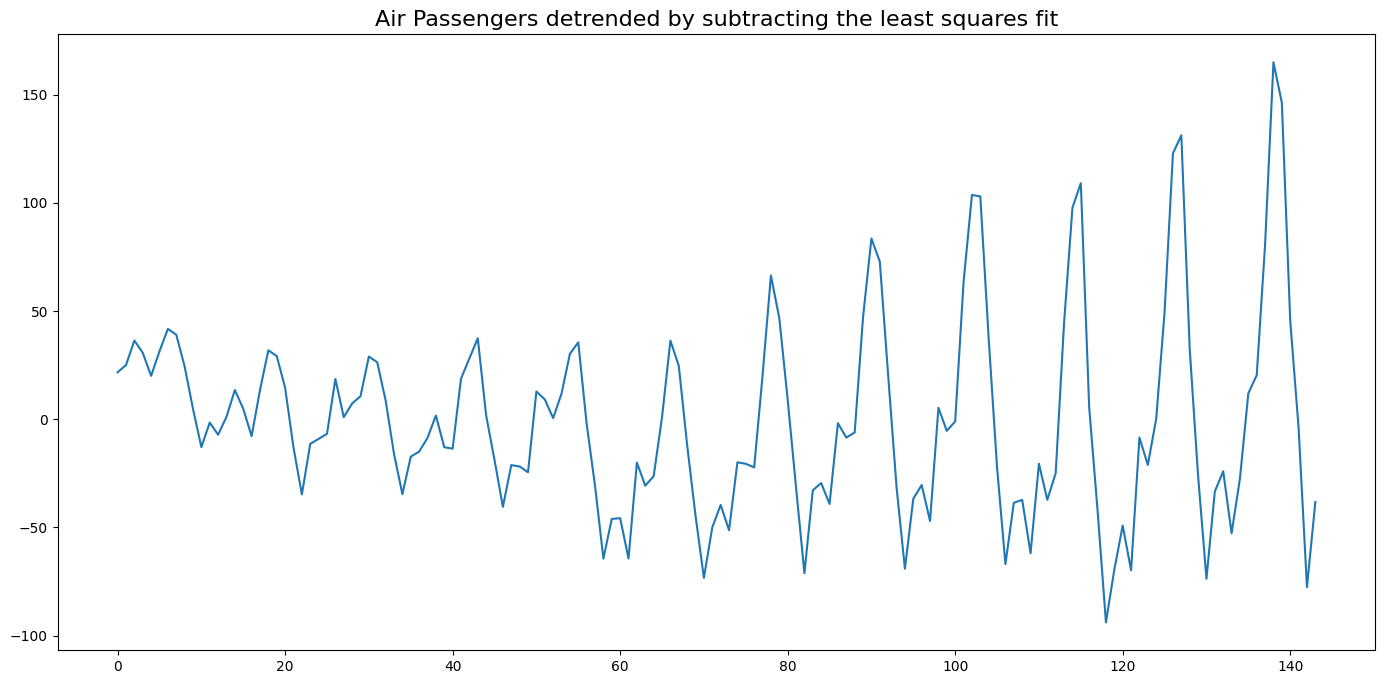

In [45]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(data['Passengers'].values)
plt.plot(detrended)
plt.title('Air Passengers detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Air Passengers detrended by subtracting the trend component')

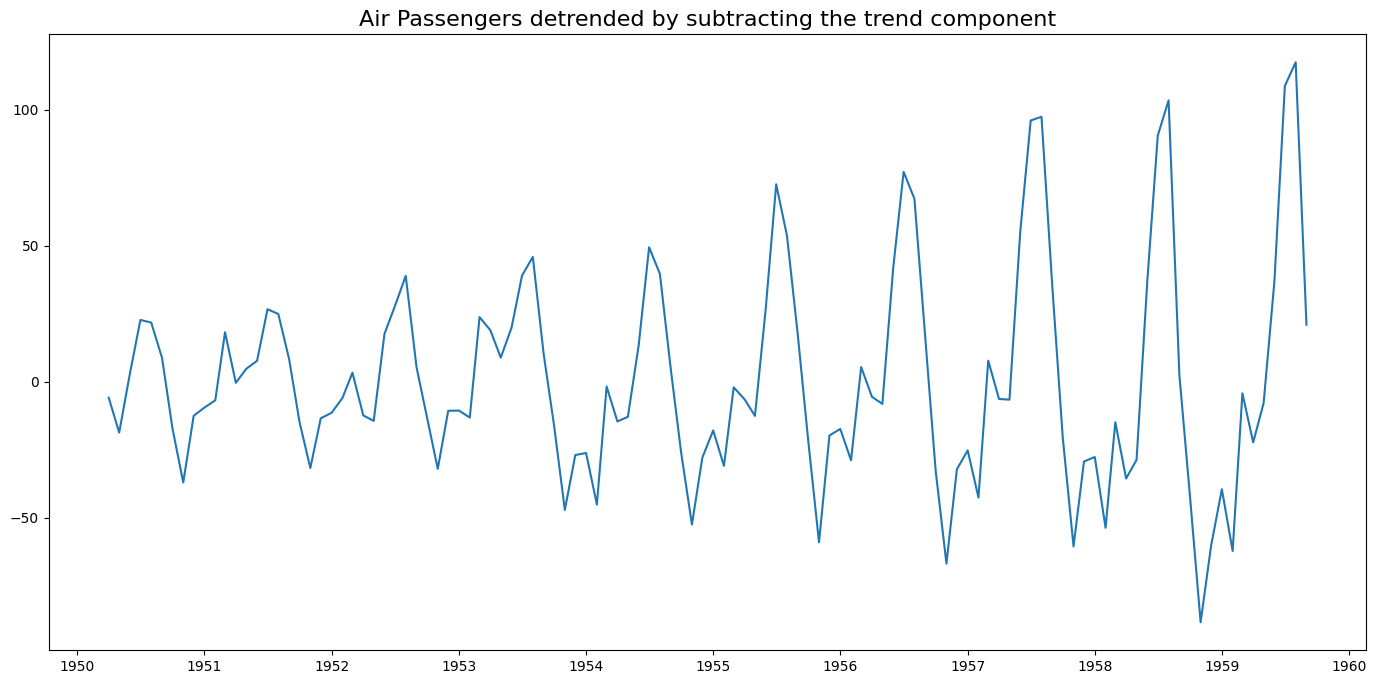

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(data['Passengers'], model='multiplicative', period=30)
detrended = data['Passengers'].values - result_mul.trend
plt.plot(detrended)
plt.title('Air Passengers detrended by subtracting the trend component', fontsize=16)

### Deseasonalize a Time Series 

There are multiple approaches to deseasonalize a time series. These approaches are listed below:

- Take a moving average with length as the seasonal window. This will smoothen in series in the process.
- Seasonal difference the series (subtract the value of previous season from the current value).
- Divide the series by the seasonal index obtained from STL decomposition.
- If dividing by the seasonal index does not work well, we will take a log of the series and then do the deseasonalizing. We will later restore to the original scale by taking an exponential.

## 8. Auto-correlation Function (ACF)

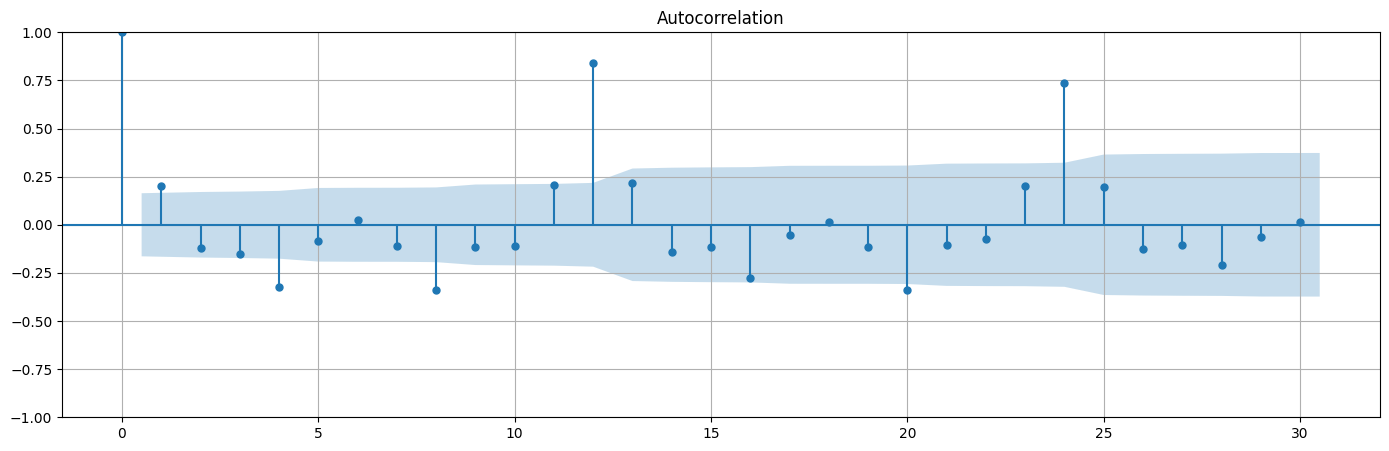

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(17,5))
plt.grid()
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## 9. Partial Auto-correlation function (PACF)

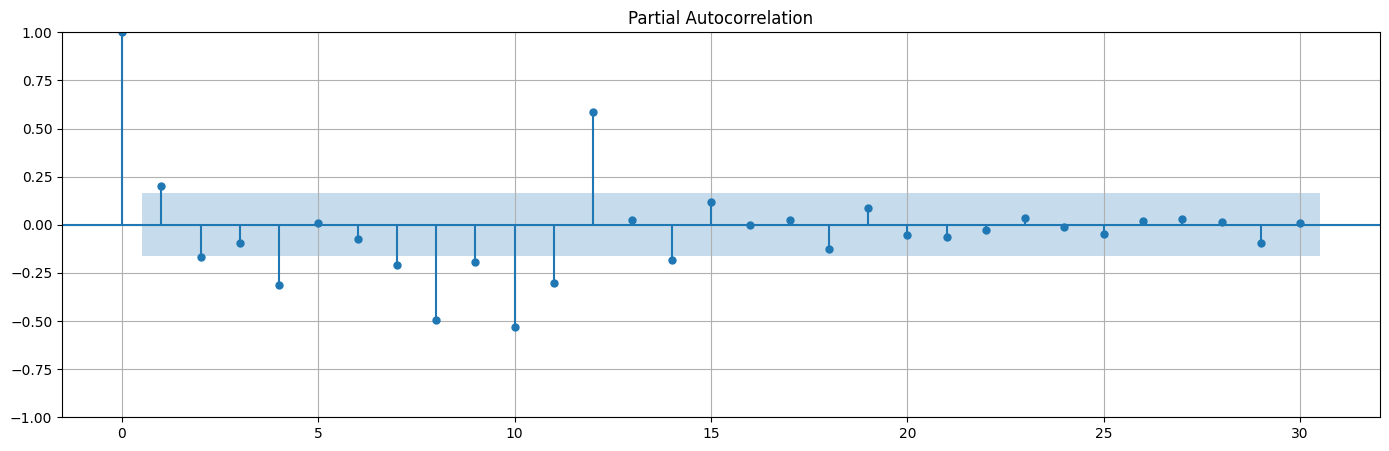

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(17,5))
plt.grid()
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [49]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [50]:
train_data_boxcox_diff[:10]

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
dtype: float64

## 10. Auto regression method (AR)

In [51]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.params)

const     0.009473
ar.L1     0.182911
sigma2    0.010733
dtype: float64


In [52]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

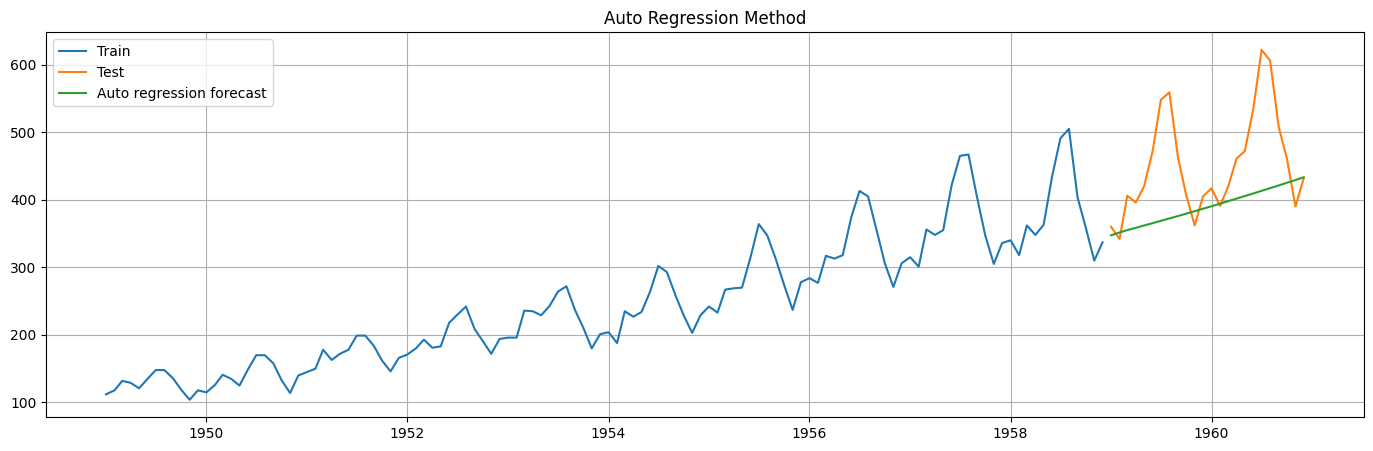

In [53]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [54]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72


## 11. Moving Average (MA)

In [55]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.009523
ma.L1     0.258490
sigma2    0.010579
dtype: float64


In [56]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

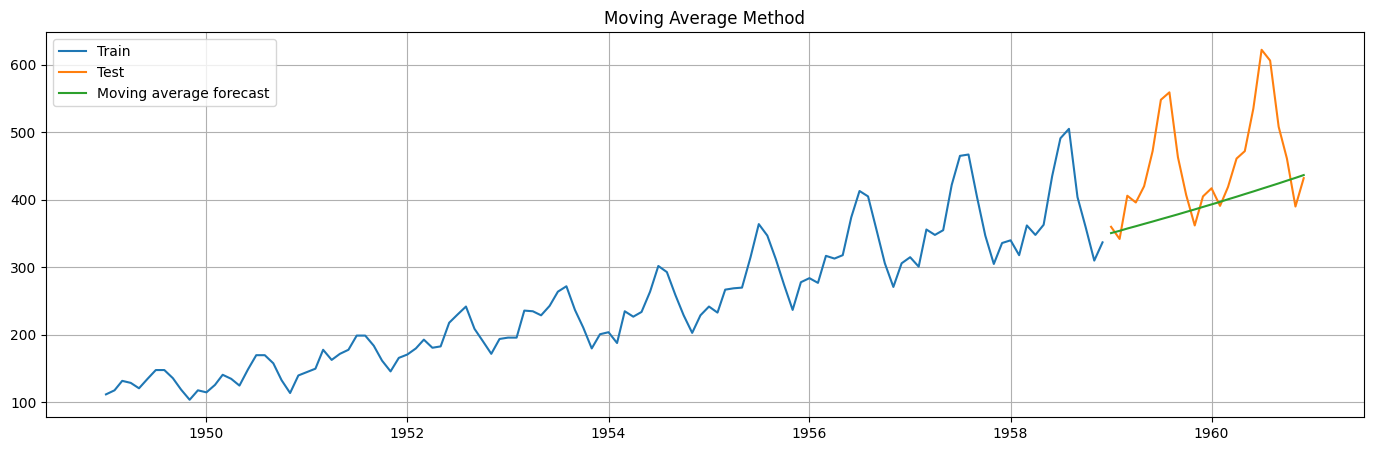

In [57]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(data['Passengers'][:train_len], label='Train')
plt.plot(data['Passengers'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72
0,Moving Average (MA) method,91.61,13.40


## 13. Auto Regressive Moving Average (ARMA)

In [59]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.009628
ar.L1    -0.581788
ma.L1     0.837584
sigma2    0.010129
dtype: float64


In [60]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

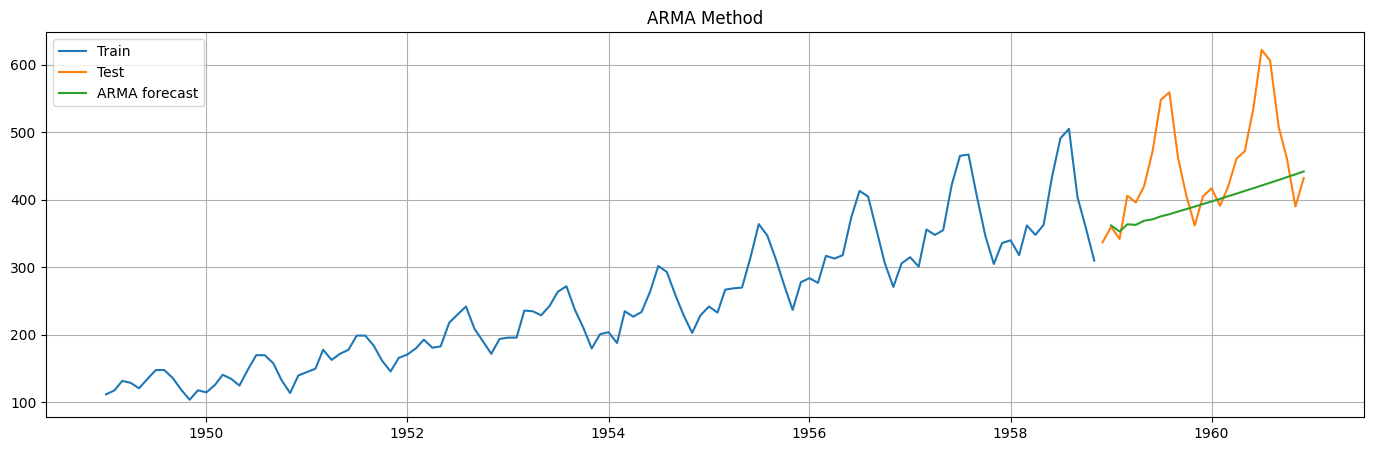

In [61]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot( data['Passengers'][:train_len-1], label='Train')
plt.plot(data['Passengers'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [62]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][train_len-1:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72
0,Moving Average (MA) method,91.61,13.40
0,Autoregressive moving average (ARMA) method,88.74,12.81


## 14. Auto Regressive Integrated Moving Average (ARIMA)

---



In [63]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

ar.L1    -0.576076
ma.L1     0.834692
sigma2    0.010198
dtype: float64


In [64]:
y_hat_arima = test.copy()
# The ARIMA model with order (1,1,1) already handles differencing internally
# So predictions are directly in Box-Cox space, not differenced
y_hat_arima['arima_forecast_boxcox'] = model_fit.predict(start=test.index.min(), end=test.index.max())
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

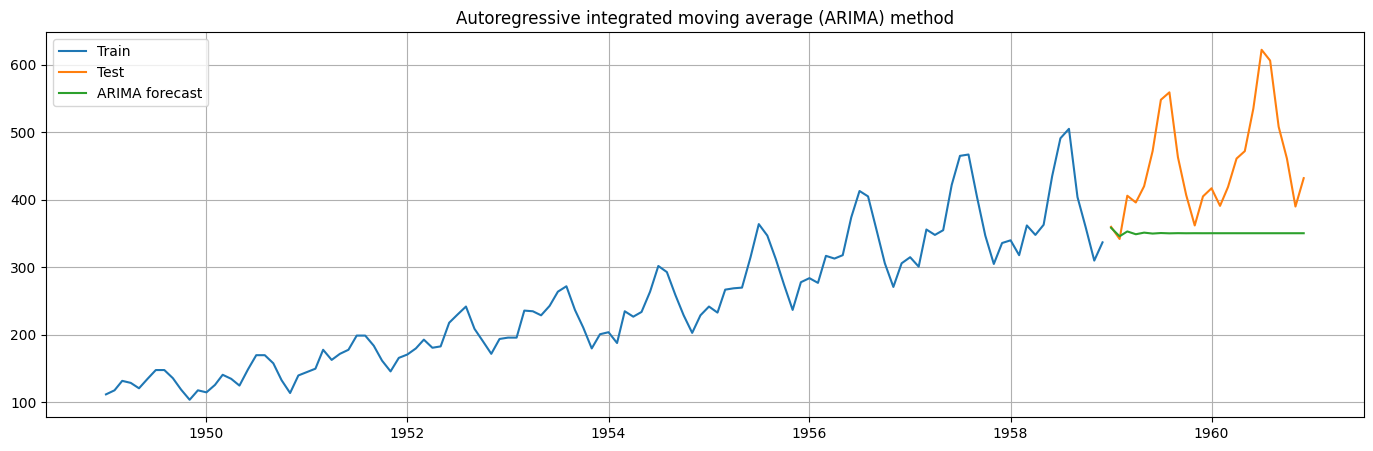

In [65]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [66]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72
0,Moving Average (MA) method,91.61,13.40
0,Autoregressive moving average (ARMA) method,88.74,12.81


## 15. Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.235486
ma.L1      -0.091859
ar.S.L12   -0.067919
ma.S.L12   -0.497001
sigma2      0.001403
dtype: float64


In [68]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

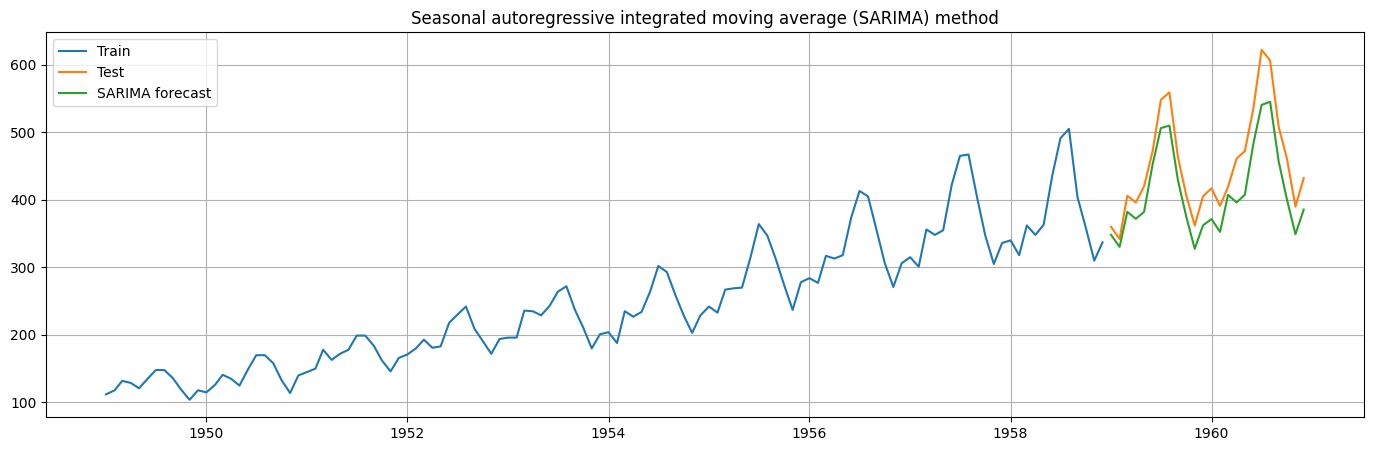

In [69]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [70]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72
0,Moving Average (MA) method,91.61,13.40
0,Autoregressive moving average (ARMA) method,88.74,12.81


## 16. Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)

In [71]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

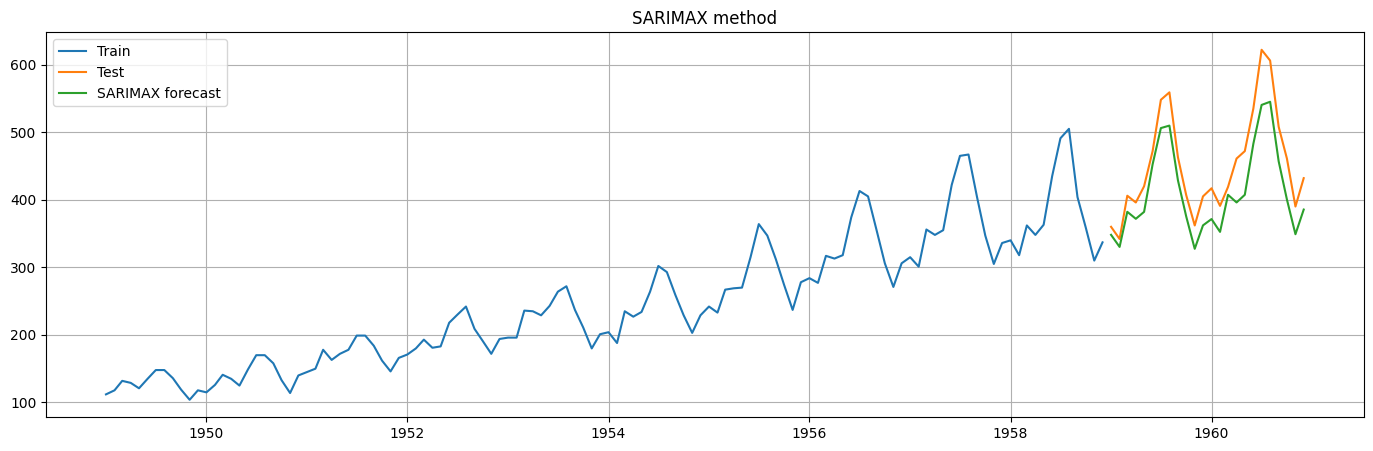

In [72]:
plt.figure(figsize=(17,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

In [73]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72
0,Moving Average (MA) method,91.61,13.40
0,Autoregressive moving average (ARMA) method,88.74,12.81


## Conclusion :

### SARIMA and SARIMAX algorithms provide us with the lowest Root Mean Square Error (RMSE) and MAPE scores, thus being the best and most developed algorithms for time series analysis

In [74]:
import pandas as pd
import statsmodels.api as sm
import matplotlib
from prophet import Prophet
from datetime import datetime
from prophet.plot import plot_plotly, plot_components_plotly
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("AirPassengers.csv")
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [75]:
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=48, freq='M')
forecast = model.predict(future)

20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:44 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
187,1964-07-31,687.336817,657.438340,718.291216
188,1964-08-31,640.790057,610.711269,670.429394
189,1964-09-30,604.016197,572.196202,629.934158
190,1964-10-31,573.222195,544.790444,601.663078
191,1964-11-30,602.881114,575.832035,631.696872


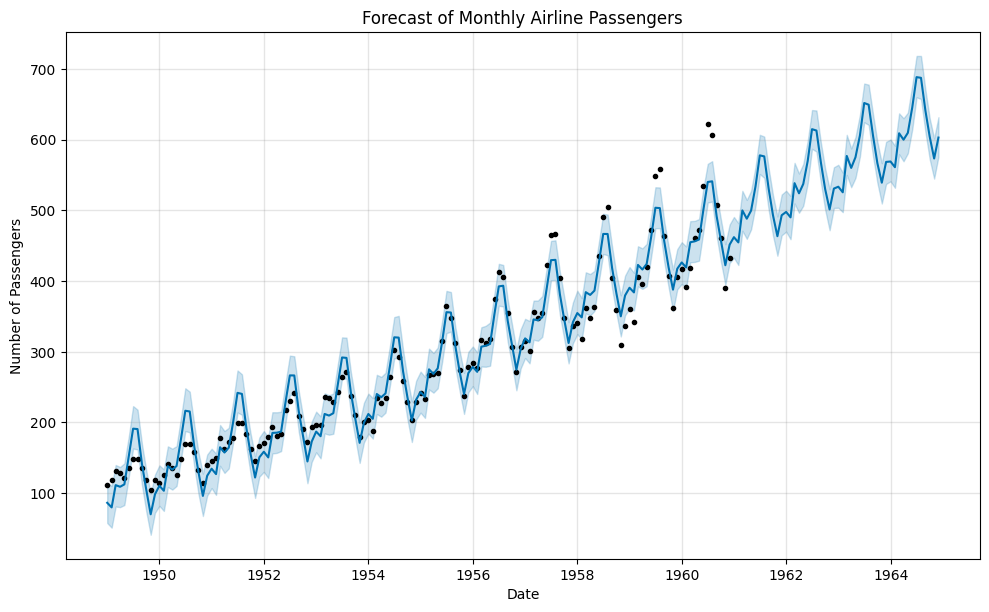

In [77]:
model.plot(forecast)
plt.title('Forecast of Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

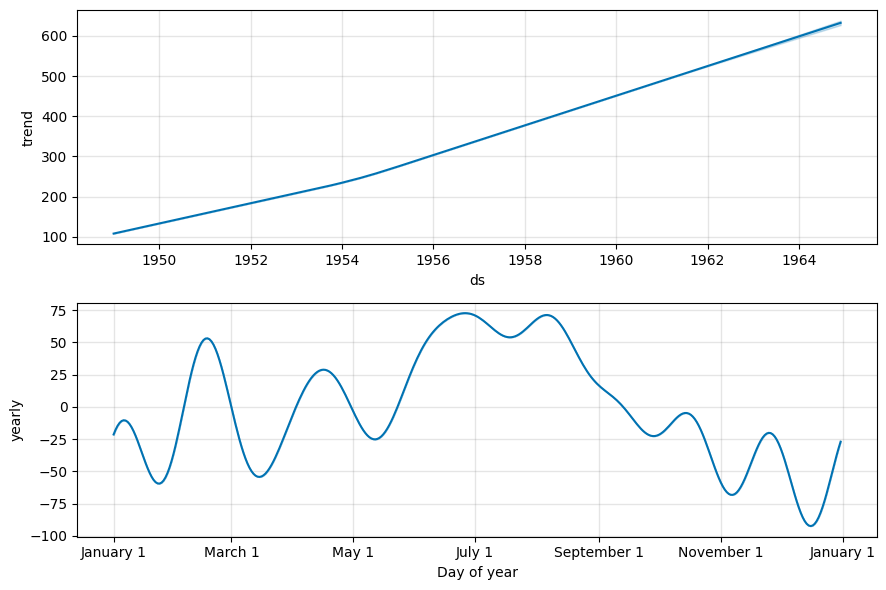

In [78]:
model.plot_components(forecast)
plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_true = df['y'].values
y_pred = forecast.loc[:len(y_true)-1, 'yhat'].values

# MAE, RMSE, and MAPE
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Add to results comparison
tempResults = pd.DataFrame({'Method':['Prophet'], 'RMSE': [rmse.round(2)],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Mean Absolute Error (MAE): 17.31
Root Mean Squared Error (RMSE): 22.42
Mean Absolute Percentage Error (MAPE): 7.21%


,Method,RMSE,MAPE
0,Naive method,137.33,23.58
0,Simple average method,219.44,44.23
0,Simple moving average forecast,103.21,15.47
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39
0,Autoregressive (AR) method,93.42,13.72
0,Moving Average (MA) method,91.61,13.40
0,Autoregressive moving average (ARMA) method,88.74,12.81


### Reinforcement Learning
- Agent (or Actor): This is our subject from the previous section. This can be the dog, a robot trying to navigate a huge factory, a video game NPC, etc.
- Environment (or the world): This can be a place, a simulation with restrictions, a video game’s virtual game world, etc. I think of this like, “A box, real or virtual, where the agent’s entire life is confined to; it only knows of what happens within the box. We, as the overlords, can alter this box, while the agent will think that god is exacting his will on his world.”
- Policy: Just like in governments, companies, and many more similar entities, ‘policies’ dictate “What actions should be taken when given a certain situation”.
- State: This is what the agent “sees” or “knows” about its current situation. Think of it as the agent’s snapshot of reality at any given moment—like how you see the traffic light color, your speed, and the distance to the intersection when driving.
- Action: action that the agent will take to achieve its goal, i.e., GET SOME COFFEE!
- Reward: Every time the actor executes an action (of its own volition), something may change in the world. For example, our agent got out of bed and started walking towards the kitchen, but then, because it is so bad at walking, it tripped and fell. In this situation, the god (us) rewards it with a punishment for being bad at walking (negative reward). But then the agent makes it to the kitchen and gets the coffee, so the god (us) rewards it with a cookie (positive reward).